<a href="https://colab.research.google.com/github/mmeisser/python_tools/blob/master/test_parse_raw_logs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plot Akra loadcell raw values

This notebook/python script does read log files collected with akra (v1.26.4 or above)

## 1. LOAD

First select the file to upload:
(run the below code section)

In [37]:
from google.colab import files
uploaded = files.upload()

#uploaded #uncomment to check the content of file



Saving AkraLog_Playback_137.csv to AkraLog_Playback_137 (1).csv


Then load the (selected) file into a (panda) data frame

In [39]:
import pandas as pd
import io

df = pd.read_csv(io.StringIO(uploaded['AkraLog_Playback_137.csv'].decode('utf-8')))
#df #uncomment to show the loaded table

## 2. GRAPH

Process the data and spit out a graph

In [63]:
import plotly.graph_objs as go
import csv
import matplotlib.pyplot as plt
import plotly.express as px


is_primary = df[' Device type']== ' Primary' #this is a column with true/false to assert if this is data for a controller
stylus_data = df[is_primary]    #therefore we only take that subset of lines for the controller (ie stylus)

nib=stylus_data[' Touchpad X value']*32768
primary=stylus_data[' Touchpad Y value']*32768
time=stylus_data['TimeStamp (ms)']

s = pd.Series(nib) #create a panda serie from NIB LOADCELL data
s.describe() #prints out stats data on serie

t = pd.Series(time) #create a panda serie from time data
t.diff()   #gives differences between samples in serie


# detect baseline (simple minimum for now) for NIB
minimum_nib = nib.array[0]
minimum_nib_array = nib.copy()

for index, value in enumerate(nib.array):
 if value < minimum_nib:
   minimum_nib = value #if we found a smaller value
 #print("Index:"+ str(index) + " - min" + str(minimum_nib))
 minimum_nib_array.array[index] = minimum_nib # place it into the array
#plt.plot(minimum_nib_array)

# detect baseline (simple minimum for now) for NIB
minimum_pri = primary.array[0]
minimum_pri_array = primary.copy()

for index, value in enumerate(primary.array):
 if value < minimum_pri:
   minimum_pri = value
 #print("Index:"+ str(index) + " - min" + str(minimum_pri))
 minimum_pri_array.array[index] = minimum_pri
#plt.plot(minimum_pri_array)


# plot graph with all series
fig = go.Figure([
    go.Scatter(
        name='Nib',
        y=nib,
        mode='lines',
        marker=dict(color='blue', size=2),
        showlegend=True
    ),
    go.Scatter(
        name='Primary',
        y=primary,
        mode='lines',
        marker=dict(color='red', size=2),
        showlegend=True
    ),
    go.Scatter(
        name='minimum_nib',
        y=minimum_nib_array,
        mode='lines',
        marker=dict(color='pink', size=2),
        showlegend=True
    ), 
    go.Scatter(
        name='minimum_pri',
        y=minimum_pri_array,
        mode='lines',
        marker=dict(color='pink', size=2),
        showlegend=True
    )
])
fig.update_layout(
    yaxis_title='adc raw value [counts]',
    title='Loadcell raw values',
    hovermode="x"
)
fig.show()

##3. ANALYSIS

First setup some variable params

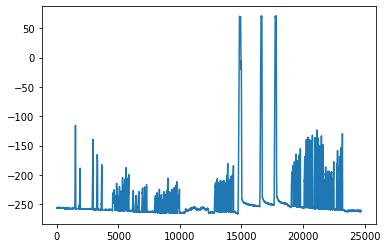

In [118]:
#@title Variable Parameters { run: "auto", form-width: "50%" }
#last_frame = nib.count()
first_frame = 0 #@param {type:"integer"}
last_frame = 8400 #@param {type:"integer"}
gF_ADC_count = 2 #@param {type:"slider", min:0, max:2, step:0.1}

plt.plot(nib.iloc[first_frame:last_frame])

Here you can plot how the minimum values captured in the log do change overtime

NIB: min=-266.503913472 max=70.499991552
PRI: min=-64.500006912 max=-19.5000008704


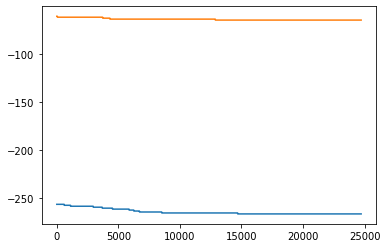

In [119]:
plt.plot(minimum_nib_array.iloc[first_frame:last_frame])
plt.plot(minimum_pri_array.iloc[first_frame:last_frame])

print("NIB: min="+str(nib.iloc[first_frame:last_frame].min())+ " max="+ str(nib.iloc[first_frame:last_frame].max()))
print("PRI: min="+str(primary.iloc[first_frame:last_frame].min())+ " max="+ str(primary.iloc[first_frame:last_frame].max()))

Evaluate the performance of this sample

In [120]:

print("NIB PARAMS ----------------------------------------")
print("Nib start value is \t\t %4.2f (in adc counts)" % (nib.array[first_frame]))
print("Nib min value is \t\t %4.2f (in adc counts)" % (nib.iloc[first_frame:last_frame].min()))
print("Nib max value is \t\t %4.2f (in adc counts)" % (nib.iloc[first_frame:last_frame].max()))
print("Nib full range is \t\t %4.2f (in adc counts)" % (nib.iloc[first_frame:last_frame].max() - nib.iloc[first_frame:last_frame].min()))
# nib minimum stability:
#minimum_nib_array.describe()
stability = minimum_nib_array.iloc[first_frame:last_frame].min() - minimum_nib_array.iloc[first_frame:last_frame].max()
print("Nib minimum variation is \t %4.2f (in adc counts) / %4.2f (gF)\n" %(stability, gF_ADC_count*stability))


print("PRI PARAMS ----------------------------------------")
print("Pri start value is \t\t %4.2f (in adc counts)" % (primary.array[first_frame]))
print("Pri min value is \t\t %4.2f (in adc counts)" % (nib.iloc[first_frame:last_frame].min()))
print("Pri max value is \t\t %4.2f (in adc counts)" % (nib.iloc[first_frame:last_frame].max()))
print("Pri full range is \t\t %4.2f (in adc counts)" % (primary.iloc[first_frame:last_frame].max() - primary.iloc[first_frame:last_frame].min()))
# primary minimum stability:
#minimum_pri_array.describe()
stability = minimum_pri_array.iloc[first_frame:last_frame].min() - minimum_pri_array.iloc[first_frame:last_frame].max()
print("Primary minimum variation is \t %4.2f (in adc counts) / %4.2f (gF)\n" % (stability, gF_ADC_count*stability))

print("COMMON PARAMS --------------------------------------")
# evaluate the correlation between nib and primary
# which is a sign of crosstalk
correlation = nib.corr(primary)
print("The crosstalk (correlation) between nib and primary is %4.2f (0 is good and 1 is bad) \n" % (correlation))




NIB PARAMS ----------------------------------------
Nib start value is 		 -256.50 (in adc counts)
Nib min value is 		 -266.50 (in adc counts)
Nib max value is 		 70.50 (in adc counts)
Nib full range is 		 337.00 (in adc counts)
Nib minimum variation is 	 -10.00 (in adc counts) / -20.00 (gF)

PRI PARAMS ----------------------------------------
Pri start value is 		 -60.50 (in adc counts)
Pri min value is 		 -266.50 (in adc counts)
Pri max value is 		 70.50 (in adc counts)
Pri full range is 		 45.00 (in adc counts)
Primary minimum variation is 	 -4.00 (in adc counts) / -8.00 (gF)

COMMON PARAMS --------------------------------------
The crosstalk (correlation) between nib and primary is 0.61 (0 is good and 1 is bad) 

